## Preprocessing

In [179]:
import numpy as np
import cv2
import os
import uuid 
import matplotlib.pyplot as plt

In [180]:
image="./S5000L00.jpg"
image2="./S5000L05.jpg"

In [181]:
def plot_image(image,title,cmap=None):
    plt.figure(figsize=(6, 6))
    if cmap is None:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

-----
------

The processing function:

Loads and resizes the input image.
Converts it to grayscale and applies blurring.
Uses Otsu's thresholding to determine a threshold for the Canny edge detector, then applies the Hough Circle Transform to detect circles.
Crops each detected circle with padding r and returns the cropped image and radius of the last detected circle.

In [182]:
def processing(image_path,r):                                
    image = cv2.imread(image_path)
    plot_image(image,"original image")
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    plot_image(image,"resized image")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(image, 11)
    plot_image(gray,"blurred image")
    ret, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 50, param1=ret, param2=30, minRadius=20,
                               maxRadius=100)
    print("circles shape before",circles.shape)
    circles = circles[0, :, :]  
    print("circles shape after",circles.shape)
    circles = np.int16(np.around(circles))  
    for i in circles[:]:
        image = image[i[1] - i[2] - r:i[1] + i[2] + r, i[0] - i[2] -r:i[0] + i[2] + r]
        radus = i[2]
    # print(image)
    return image, radus

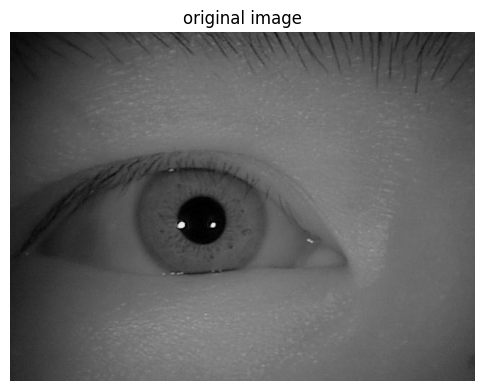

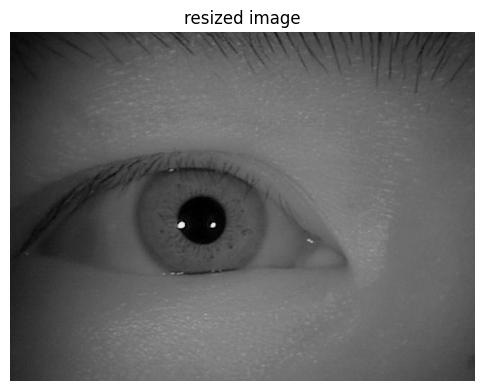

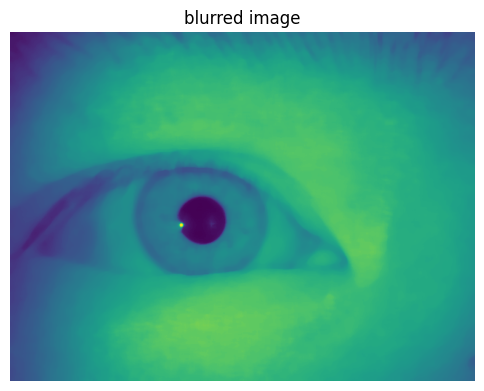

circles shape before (1, 1, 3)
circles shape after (1, 3)


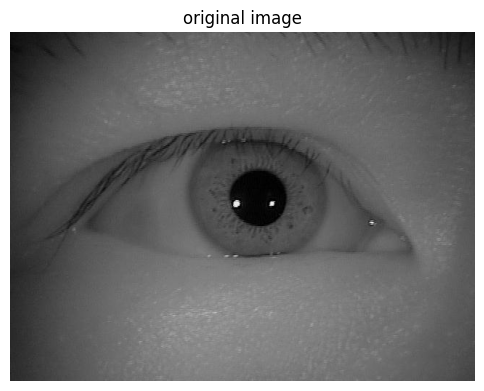

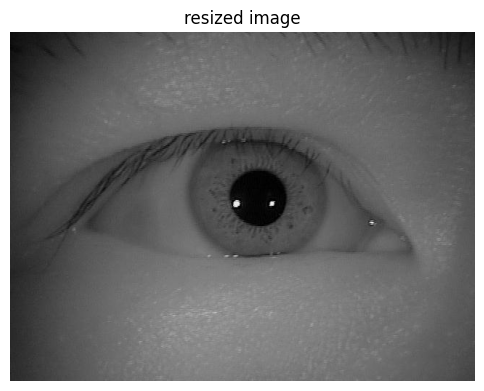

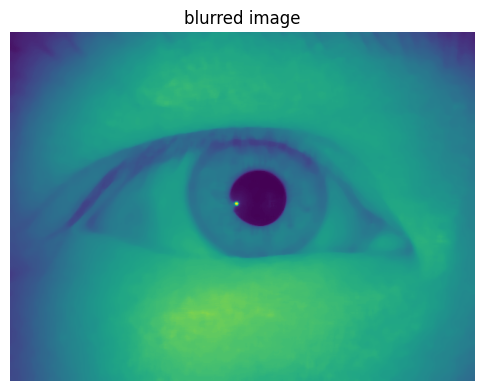

circles shape before (1, 1, 3)
circles shape after (1, 3)


In [183]:
processed_image,radius=processing(image,55)
processed_image2,radius2 = processing(image2,55)

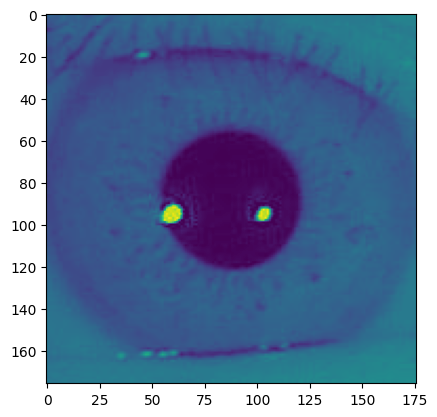

In [184]:
plt.imshow(processed_image)

----------
---------

In [185]:
def reflection_removal(processed_image):
  ret,mask=cv2.threshold(processed_image,150,255,cv2.THRESH_BINARY)
  kernel=np.ones((5,5),np.uint8)
  dilation=cv2.dilate(mask,kernel,iterations=1)
  dst=cv2.inpaint(processed_image,dilation,5,cv2.INPAINT_TELEA)
  return dst

In [186]:
def daugman_normalizaiton(image, height, width, r_in, r_out):    
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height,width, 3), np.uint8)
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    return flat  # liang

In [187]:
lolimg = cv2.imread("processed_image_marsoma.png",0)

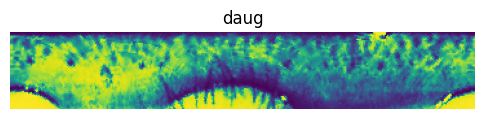

In [188]:
result2 = daugman_normalizaiton(processed_image,60,360, radius, 55)
result2 =  cv2.cvtColor(result2, cv2.COLOR_BGR2GRAY)
result2 = cv2.equalizeHist(result2)
plot_image(result2, "daug")

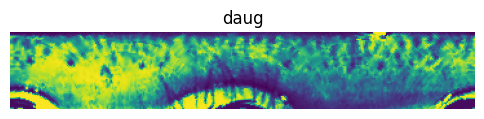

In [189]:
result3 = daugman_normalizaiton(lolimg,60,360, radius, 55)
result3 =  cv2.cvtColor(result3, cv2.COLOR_BGR2GRAY)
result3 = cv2.equalizeHist(result3)
plot_image(result3, "daug")

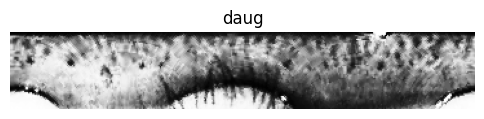

In [190]:
# result2 = daugman_normalizaiton(processed_image,60,360, radius, 55)
# result2 =  cv2.cvtColor(result2, cv2.COLOR_BGR2GRAY)
# result2 = cv2.equalizeHist(result2)
plot_image(result2, "daug",cmap="gray")

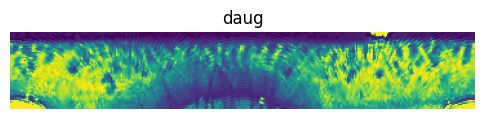

In [191]:
result4 = daugman_normalizaiton(processed_image2,60,360, radius, 55)
result4 =  cv2.cvtColor(result4, cv2.COLOR_BGR2GRAY)
result4 = cv2.equalizeHist(result4)
plot_image(result4, "daug")

In [192]:
# implementation of  equation for 2D Gabor wavelets
from skimage.util import view_as_blocks
def gabor(rho, phi, w, theta0, r0, alpha, beta):

    return np.exp(-w * 1j * (theta0 - phi)) * np.exp(-(rho - r0) ** 2 / alpha ** 2) *\
           np.exp(-(-phi + theta0) ** 2 / beta ** 2)
           
def gabor_convolve(img, w, alpha, beta):
    theta0 = np.linspace(0, 2 * np.pi, img.shape[1])

    rho = np.array([np.linspace(0, 1, img.shape[0]) for i in range(img.shape[1])]).T
    x = np.linspace(0, 1, img.shape[0])
    y = np.linspace(-np.pi, np.pi, img.shape[1])
    xx, yy = np.meshgrid(x, y)

    return rho * img * np.real(gabor(xx, yy, w, 0, 0, alpha, beta).T), \
           rho * img * np.imag(gabor(xx, yy, w, 0, 0, alpha, beta).T)



def iris_encode(img, dr=15, dtheta=15, alpha=0.4):

    mask = view_as_blocks(np.logical_and(20 < img, img < 255), (dr, dtheta))
    #&creating a mask to exclude non-iris pixels

    norm_iris = (img - img.mean()) / img.std() 
    # image normalization

    patches = view_as_blocks(norm_iris, (dr, dtheta))
    print("ana",patches.shape) 
    # split image to blocks


    code = np.zeros((patches.shape[0] * 3, patches.shape[1] * 2))
    # large the size of code to add the information from three frequency and from real and imaginary part
    
    code_mask = np.zeros((patches.shape[0] * 3, patches.shape[1] * 2))
    for i, row in enumerate(patches): 
        for j, p in enumerate(row):
            for k, w in enumerate([8, 16, 32]): #change the frequency of wavelet
                wavelet = gabor_convolve(p, w, alpha, 1 / alpha)
                code[3 * i + k, 2 * j] = np.sum(wavelet[0]) #calculate the real part
                code[3 * i + k, 2 * j + 1] = np.sum(wavelet[1]) #calculate the imaginary part
                code_mask[3 * i + k, 2 * j] = code_mask[3 * i + k, 2 * j + 1] = \
                    1 if mask[i, j].sum() > dr * dtheta * 3 / 4 else 0
    
    
    code[code >= 0] = 1
    code[code < 0] = 0
    return code, code_mask



In [193]:
def visualize_iris_code(img, dr=15, dtheta=15, alpha=0.4):
    # Generate the iris code and mask
    code, code_mask = iris_encode(img, dr, dtheta, alpha)

    # Plotting the iris code
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Iris Code")
    plt.imshow(code, cmap="gray")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.title("Code Mask")
    plt.imshow(code_mask, cmap="gray")
    plt.colorbar()

    plt.show()


ana (4, 24, 15, 15)


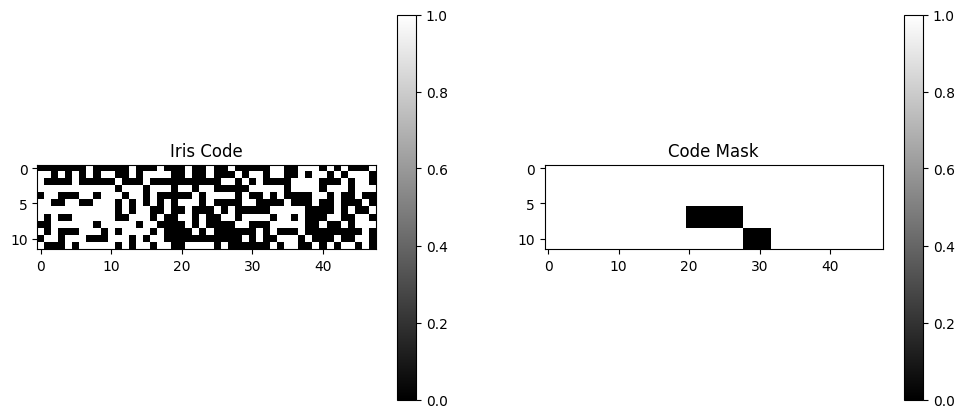

In [194]:
visualize_iris_code(result2)

ana (4, 24, 15, 15)


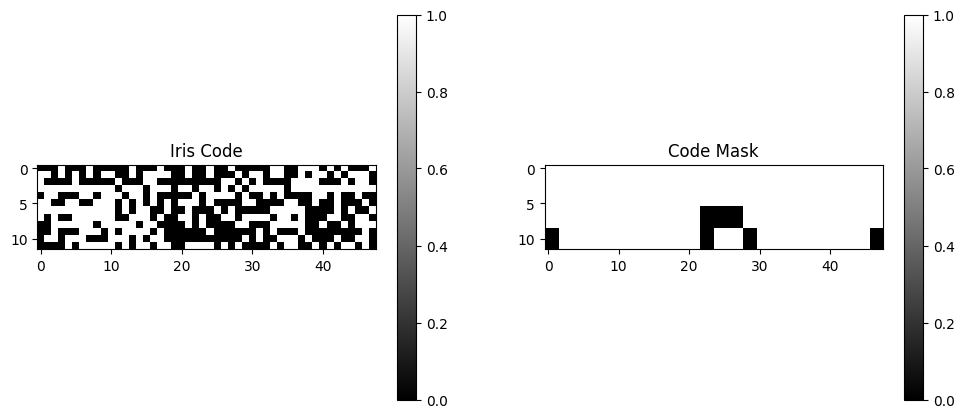

In [195]:
visualize_iris_code(result3)

ana (4, 24, 15, 15)


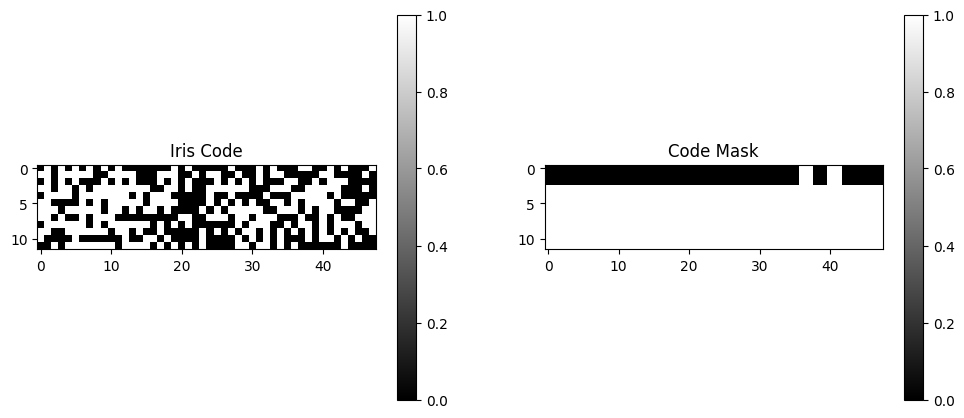

In [196]:
visualize_iris_code(result4)

--------------------
--------------------

## Modeling

In [197]:
def hamming_distance(code1, code_mask1, code2, code_mask2):
    """
    Calculate the Hamming distance between two iris codes, accounting for masks.
    
    Parameters:
        code1, code2: np.ndarray
            Binary iris codes to be compared.
        code_mask1, code_mask2: np.ndarray
            Binary masks for the respective iris codes, where 1 indicates valid regions.
    
    Returns:
        float
            Normalized Hamming distance (0 means perfect match, 1 means completely different).
    """
    # Ensure the masks are binary (0s and 1s)
    combined_mask = code_mask1 * code_mask2  # Intersection of the two masks
    differing_bits = np.sum((code1 != code2) & (combined_mask == 1))  # Count differing bits in valid regions
    valid_bits = np.sum(combined_mask)  # Count the valid bits to normalize

    # Avoid division by zero if no valid bits are found
    if valid_bits == 0:
        return None  # or return 1.0 if you consider no overlap as completely different
    
    # Calculate normalized Hamming distance
    hamming_dist = differing_bits / valid_bits
    return hamming_dist


In [198]:
code1, code_mask1 = iris_encode(result2, 15, 15, 0.4)
code2, code_mask2 = iris_encode(result3, 15, 15, 0.4)
code3, code_mask3 = iris_encode(result4, 15, 15, 0.4)

ana (4, 24, 15, 15)
ana (4, 24, 15, 15)
ana (4, 24, 15, 15)


In [199]:
# Example usage
# Assuming code1, code_mask1, code2, code_mask2 are binary numpy arrays representing two iris codes and their masks
hamming_dist = hamming_distance(code1, code_mask1, code2, code_mask2)
print("Hamming Distance:", hamming_dist)

Hamming Distance: 0.013409961685823755


In [200]:
hamming_dist = hamming_distance(code1, code_mask1, code3, code_mask3)
print("Hamming Distance:", hamming_dist)

Hamming Distance: 0.46078431372549017
